# MMMC the 2023 update

See the [original blog post](http://www.mglerner.com/blog/?p=16) for details and history. Here's the short story: in my Statistical and Thermal Physics class, we want to use Monte Carlo simulations to generate brackets for March Madness. There are at least two obvious ways to go about this:

 1. Make some function that tells us the chance that team A beats team B, then flip coins for each matchup. That gets you one bracket. Repeat 100,000 times, collect statistics. This is the way Nate Silver's 538.com handles simulations for [basketball](http://fivethirtyeight.com/interactives/march-madness-predictions-2015/#mens), [elections](http://fivethirtyeight.com/interactives/senate-forecast/), etc, and I should probably implement it (note to self/motivated students: it's as easy as just generating 100,000 new brackets at a given temperature).
 
 2. Generate one bracket, then do a Monte-Carlo walk through bracket space. This is tougher. We have to figure out how to make a move in bracket space, which is part of the fun of Monte Carlo simulations in general. To see how this is done, check out the code in `Bracket.swap` and `Brackets.simulate`.
 
 
Please also see the [2015 Version](MMMC2015.ipynb) for more information, including what we did in 2015 to calibrate "temperature."

As you can tell, we take option 2 above. I've made things a bit nicer from a user standpoint this year; here's a walkthrough. First, load up our standard IPython setup

In [1]:
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
#from bqplot import pyplot as plt
from matplotlib import pyplot as plt
from IPython.display import HTML

In [2]:
import imp
from MarchMadnessMonteCarlo import KenPomeroy
imp.reload(KenPomeroy)
import MarchMadnessMonteCarlo as MMMC
imp.reload(MMMC)
teams = MMMC.Teams['south']
b = MMMC.Bracket(teams=teams,T=0.5)
print (b)

N. Carolina (1)                                              
Texas So. (16)            N.  (1)                            
Arkansas (8)                                                 
Seton Hall (9)            Set (9)  Set (9)                   
Minnesota (5)                                                
Middle Tenn. (12)         Mid (12)                           
Butler (4)                                                   
Winthrop (13)             But (4)  Mid (12) Mid (12)         
Cincinnati (6)            Kan (11) Kan (11) Kan (11) Mid (12)
Kansas St. (11)                                              
UCLA (3)                  Ken (14)                           
Kent St. (14)                                                
Dayton (7)                Day (7)  Day (7)                   
Wichita St. (10)                                             
Kentucky (2)              Ken (2)                            
N. Kentucky (15)                                             
Total br

/var/folders/4w/ssz2zjl56pxgf3w8b2b78c2c0000gr/T/ipykernel_68822/2338544252.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [ ]:
sr = MMMC.simulate(1000,['Kentucky','Wisconsin','Villanova','Duke'],0.5)
MMMC.showstats(sr,newfig=True)

In [12]:
def adjEM_energy_gain(winner, loser):
    strength = MMMC.RAS.kenpom['AdjEM']
    A,B = strength[winner], strength[loser]
    result = -(strength[winner] - strength[loser])
    return result

def def_energy_gain(winner,loser):
    strength = MMMC.RAS.kenpom['AdjD']
    # Lower numbers are better
    A,B = strength[winner], strength[loser]
    result = A/B
    #result = A-B
    return result

MMMC.set_energy_function(def_energy_gain)

# What should our temperature be?

If we had chosen option 1 at the top, we'd just flip coins with a given probability of winning. Here (and this may be a questionable decision), we need to set an overall temperature for our simulation. Intuitively, the higher the temperature, the closer we come to a random outcome. The lower the temperature, the closer we come to a "best seed always wins" bracket. If we're going to make sense of temperature, we should pick a reasonable energy function.

We can use [KenPom](http://www.kenpom.com)'s `AdjEm` (log5 is no longer used. See [here](http://kenpom.com/blog/ratings-methodology-update/) defined as

```python
def log5_energy_game(winner, loser):
    A,B = strength[winner],strength[loser]
    # see http://207.56.97.150/articles/playoff2002.htm
    win_pct = (A-A*B)/(A+B-2*A*B)
    return -win_pct
```

Conveniently, that's coded up for you in MarchMadnessMonteCarlo.examples.

Later on, we could make a fancy energy function with, e.g., a weighted average of KenPom, Jeff Sagarin, and the NCAA rankings. 

Now, what should our actual temperature be? Historically, we know that an 8 seed vs. a 9 seed should essentially be a tossup. So, as a proxy here, we could just look at the chance of an 8 seed winning over a range of temperatures, and pick the point where it's pretty close to 0.5.

In [18]:
def winpct8(team8,team9,T,numtrials=1000):
    results = [MMMC.playgame(team8,team9,T)[0] == team8 for i in range(numtrials)]
    return np.average(results)
def plotwins(team8,team9,numtrials=10000):
    Ts = np.linspace(0,1,100)
    pct = [winpct8(team8,team9,T,numtrials) for T in Ts]
    plt.plot(Ts,pct,label='{t1} vs. {t2}'.format(t1=team8,t2=team9))
    plt.xlabel('T')
    plt.ylabel('winpct')

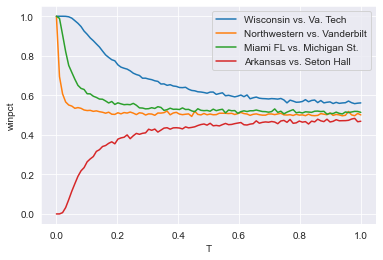

In [19]:
plt.clf()
plotwins('Wisconsin','Va. Tech')
plotwins('Northwestern','Vanderbilt')
plotwins('Miami FL','Michigan St.')
plotwins('Arkansas',"Seton Hall")
plt.legend()
plt.show()

In [ ]:
MMMC.playgame('Wisconsin','Va. Tech',10)

/Users/mglerner/coding/MarchMadnessMonteCarlo/MarchMadnessMonteCarlo/Brackets.py:63: RuntimeWarning: overflow encountered in exp
  boltzmann_factor = exp(-ediff/T)


Lowest energy bracket
Kentucky (2)                               
Wisconsin (8)             Wis (8)          
Villanova (1)             Vil (1)  Wis (8) 
Duke (2)                                   
Total bracket energy: 2.9451951068216125

Most common bracket (142)
Kentucky (2)                               
Wisconsin (8)             Wis (8)          
Villanova (1)             Vil (1)  Wis (8) 
Duke (2)                                   
Total bracket energy: 2.9451951068216125



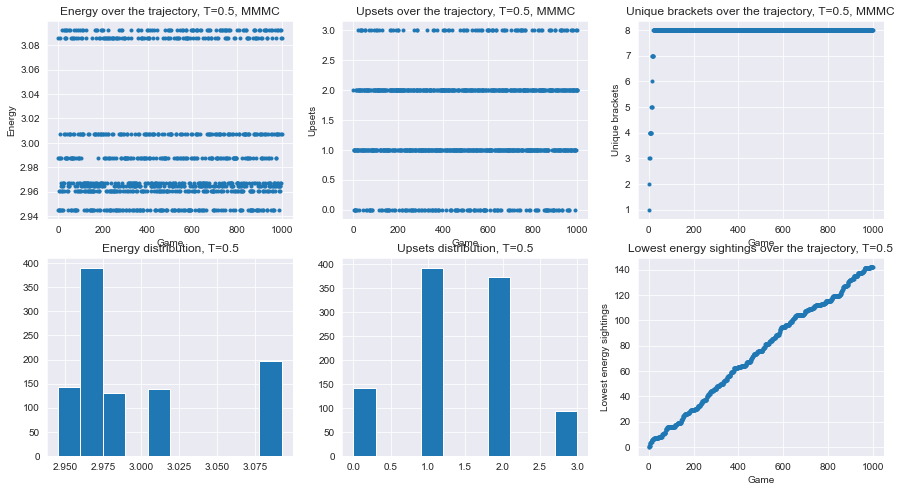

In [20]:
sr = MMMC.simulate(1000,['Kentucky','Wisconsin','Villanova','Duke'],0.5)
MMMC.showstats(sr,newfig=True)